In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

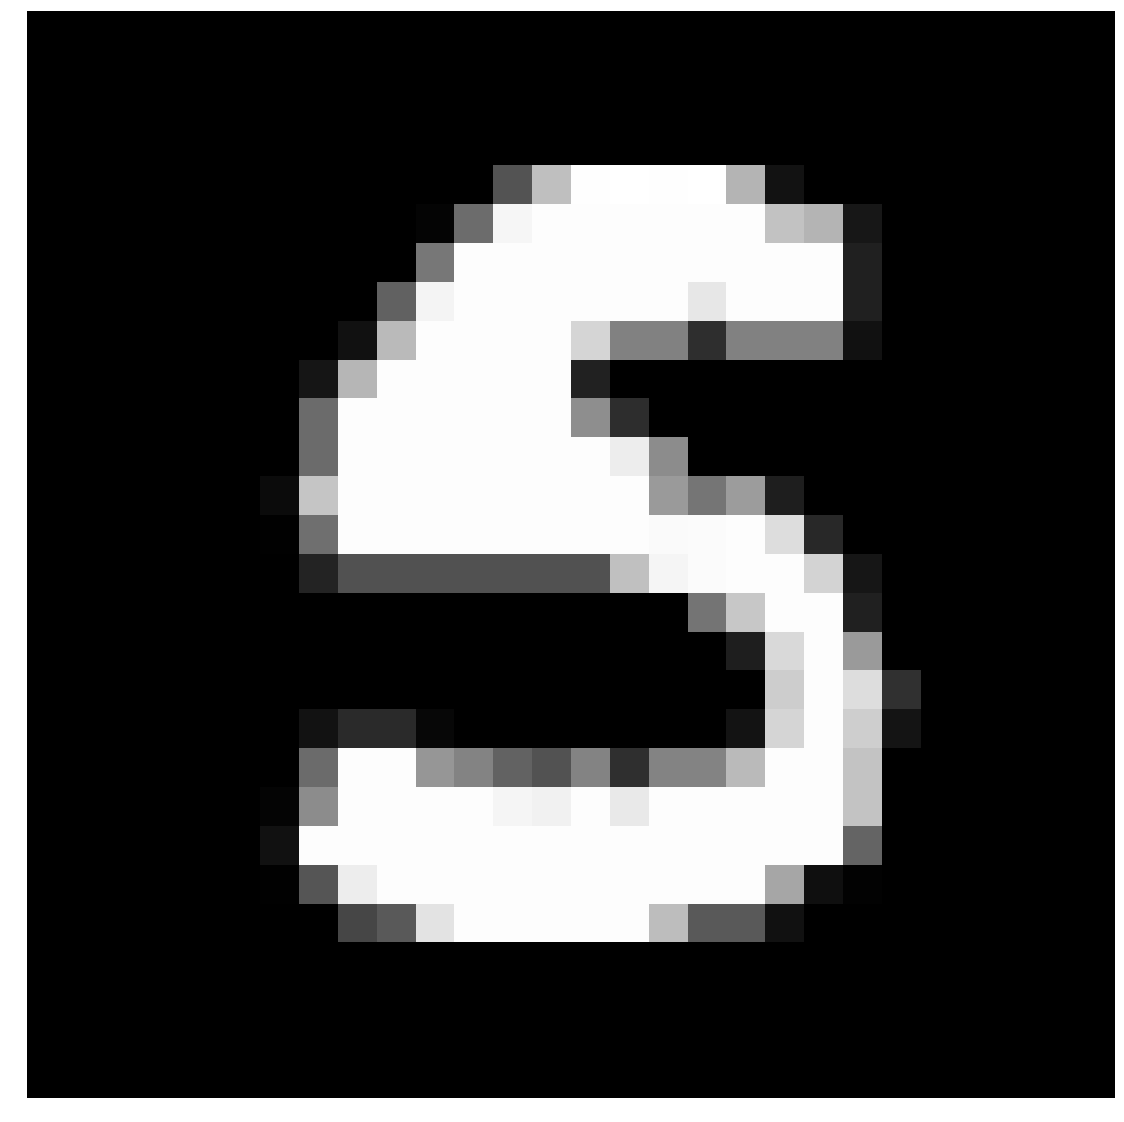

In [2]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

(trainX, trainy), (testX, testy) = mnist.load_data()
zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [39]:
#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.asarray([0.0]*(X.shape[0]+b+d)*(X.shape[1]+a+c)*X.shape[2]).reshape(X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2])
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    s=str(X.dtype)
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)

def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    Exit=np.asarray(Y*0)
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.asarray(Y*0).astype('int64')
    Truth2=np.asarray(Y*0).astype('int64')
    Pure=np.asarray(Y*0)
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[list(range(i, Y.shape[0], mat[0]))][:,list(range(j, Y.shape[1], mat[1]))]
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(list(range(i,Y.shape[0],mat[0]))),np.asarray(list(range(j,Y.shape[1],mat[1]))))]=X
    Y=Y*dim
    return Y

def dense_forw(W, L):
    return W*L

def dense_back(W, X, Der, cn):
    s1=cn*(Der*X)
    s2=cn*(W.T*x)
    return (s1, s2)

def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0

def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    for i in range(pred.shape[0]):
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.0000001):
                pred[i,0]=0.0000001
            elif(pred[i,0]>0.999999):
                pred[i,0]=0.999999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
    return (der, summ)

#ccn - learning rate, loopz - number of iterations, streetcleaner - hardcoded number of weights in first Fully connected layer
ccn=0.02
loopz=30000
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(10*20)]).reshape(10,20))


sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""
    
    
    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    
    """#Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""

    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    s2=sigmoid_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)
    
    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)
    
    #Back - 2.FC
    dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    dk1=w2.T*dk2

    #Back - 1.FC
    dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    dk0=w1.T*dk1
    

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    mtb2=[0]*10
    mtb3=[0]*10
    mtb4=[0]*10
    mtb5=[0]*10
    mtb6=[0]*10
    mtb7=[0]*10
    mtb8=[0]*10
    """for i in range(10):
        mtb8[i]=pool_back(dkl[i], (2,2), Face2)
        cz=m6[i].shape
        nw=mtb8[i].shape
        mtb8[i]=mtb8[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        #print(m6[i].shape, mtb8[i].shape)
        mtb7[i]=relu_back(m6[i], mtb8[i])
        mtb6[i], Dr2=conv_back(m4[i], matt2[i], mtb7[i])"""
    
    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    w2-=weight_delta2*ccn
    matt-=Dr*ccn
    #matt2-=Dr2*ccn
    

t2=time.time()
print(t2-t1)
print(s4)

7.015777588511776
8.220787009784699
8.424530643181313
5.977923642366833
8.045644001747247
9.571541994434964
5.772968906580789
9.00424894084433
4.793238321435087
5.569466230551866
9.450844094477093
6.571759282831013
8.211818270172532
5.835355897974529
4.29911624667727
6.216993163017343
5.8824424920927685
5.381318849687278
5.138023014343228
4.35089140788752
7.056462791180229
4.244763951526933
3.7102177791012867
2.880945208129644
3.96164945733255
4.809207879661041
3.757902344292399
5.376117201959356
3.6313686796496976
5.0544076002324925
5.109593212122738
3.8234417531770823
4.140847459403464
3.8323775286251873
4.077860161876145
4.2186642071510265
2.835772141396428
3.685684533116122
3.9175264101823424
3.2030671946382663
3.4289111427444023
4.754385903136972
3.4114891489267607
3.0821851292459
4.121086946515069
3.491001981140996
3.4136081755752152
4.324333797203785
4.15403340609396
5.121362279133289
5.625732762660445
3.320117340984108
3.7309815154227812
3.0101863200371035
3.133323262085654
3.0

2.6329619115324694
2.018670672147256
3.722668547254814
2.117235409938395
2.7599136283992696
1.6055494442562566
3.034606521368038
2.4169627934325963
3.3590726887829456
2.898539486557538
2.8803076695877605
3.930814366749639
2.481869773226645
3.85460350438108
1.5777127359406489
2.171282071529152
2.7715373551604965
2.9489167255618876
3.0438453910499157
3.7915327245820385
2.4608113004439027
2.299428179975452
2.9814453924450053
1.622272750930044
3.567781682820973
3.0950532159069746
3.2581179569936394
3.4444342487981285
3.265630736301382
2.6764864985492043
1.7957719266310292
1.5121634090798959
2.55177332029517
3.4702278631181707
2.9058616709371514
3.9897268548271443
3.76095204514943
2.4155774742305085
3.4866330386486837
3.574063617232387
4.150514958120719
3.41158235674262
3.3273004892617486
3.1870862155439013
2.3106592169195914
2.9783092656722636
1.8141422940556318
1.4597496962490482
2.9708574516532367
1.6990962308652406
3.4362642215500165
3.0811863593497106
2.5113742713586498
3.0493095978657

1.4083270771647918
3.339813550859668
2.765770819963118
2.1878050334130177
3.2467182338346547
3.05455509532242
2.5568482562504466
1.774159444545033
1.286524966818092
1.764378740131822
3.3665561320273603
2.1462586635996823
2.9267422774200003
2.538888094355484
2.6888443003064726
1.9078591937384206
1.768604992806992
1.3075622734493841
3.3059089895200136
2.5776348729157235
2.144517696227773
2.764585770876989
3.0287753958914316
1.8273932084076363
3.2319409638461374
2.290112744250952
1.651910464682906
3.9842148759428038
4.032928940392329
2.4466230987234776
1.3192538780024947
2.1366675792301466
3.0810818297807425
1.7674730413053483
2.1472652591845875
3.5495959182615477
3.2425129451386097
1.862697774631499
2.400289108386502
1.6516806933414312
1.252244366259683
3.0609878908098787
3.3239266629257624
1.5257326940347036
2.659924466017558
2.9774798886064793
1.6268299427999597
2.0332780882612083
1.470819221212396
3.075531651323863
1.2047373294213315
1.3252881482900765
2.97967271390582
2.1374415739856

2.925935152945903
2.3441962301299126
3.097003070673428
1.757387880840414
1.8861020501186714
1.9021175170219593
1.4176639045835306
1.4326455717063762
2.0715523101631814
1.3307251930091262
1.2284204409132846
1.7005373909857084
2.322267966446349
1.902774106421718
2.225735737415791
3.3903906564185347
1.9808849450108026
1.586401295551918
3.097228366070002
1.0226659425918114
3.107000489822568
2.1181202907251464
2.5836483790122853
1.7709372656880344
1.3241840750547902
3.1043333526431405
3.024737862270036
2.085201512037896
2.531399258074862
1.5564281742214456
1.614703862084857
1.2734600198293402
1.5164915801480277
1.1548508123585604
2.4998747852799204
1.06529002798574
1.384394055596145
1.9440451220627364
2.0629695671853736
2.546557264210643
3.7368243609834164
1.1160025674427145
4.037259014230427
1.1013544125078139
3.433471463635315
1.5099996648400957
2.1601519731022694
1.9554385292709426
1.7356633912571362
2.3950100479017644
2.7427580134866467
1.8597489100501052
2.3956213970297466
1.5699826932

3.4081373505674053
1.0924364434995784
1.45431747621744
2.2624243470947754
2.246254225978613
1.1122577628833248
2.434923277005341
2.036000587964894
1.2530457074180401
2.1732755451284733
3.9230705496570564
1.0268699375327968
2.680097156259098
1.3900979118215728
1.312421655109513
2.319389616065302
0.9046534152534657
0.8775265666052152
1.7729417216758157
0.9693227348287415
3.2762223999549596
1.0095177154521286
2.735794185442568
1.016542406358066
1.264732507569032
1.5094273241985887
1.988275340551442
1.0583297989457814
2.1318253051840177
1.580802596982345
1.0728855546688643
1.1298801518784298
2.5328758539807534
2.705514749282492
0.9057816713392097
1.0816752150551578
2.0673854395840308
1.8000560351520982
2.983849678144232
2.667901256333878
1.7037829069026122
1.9138170968936352
2.5466834056412595
1.0716499285062921
1.0341129875433872
1.0939133040735762
1.0014410892996435
1.7238957883720842
2.4852411926581706
3.011282522001285
2.3380031512496724
1.069063784915265
0.89216830887943
2.85933351035

3.0388530174687562
2.633154833709603
2.7712361334674176
1.0856814490227178
0.7895077552741889
0.8136442363627163
2.266733197867228
0.6602935778449394
2.9548417233513504
1.5802337384523155
1.4612556680905338
1.5272932746271195
3.764607660105114
0.9059738327979049
3.1640823432359184
1.6383179699157098
1.255129028595977
0.7743279221611433
2.5806168864142665
2.2703968828890737
3.0729431371075653
1.5816450460928333
1.1545991154980806
0.8967843175354876
1.2787242657212303
0.9689376477543669
1.5489559290554646
0.9099114338142189
1.2029642403059024
0.8748748569503682
0.7846037063380539
0.9938269735473799
1.1484013725724056
2.4565845480348405
0.859158112601429
0.8478508801587943
4.018903076376518
2.536530086379122
3.176972196812264
1.1965843179907454
1.1935690400765715
1.1064168077056646
1.5472330236810943
0.5319002736293431
1.4399805528862932
0.7663051828058889
2.009836676827946
1.4210033056455156
0.9743079996562658
2.0750502898592367
1.3414302184914983
0.8325684857776445
1.078386050581172
0.8

0.7959002047230864
3.5755185702887684
0.7095348821004728
5.117939569015978
0.526520620742132
1.5229816219472592
0.6376953055608611
1.1794343521188004
0.6848017066727531
1.6520801552534958
1.4373874804574103
3.326780864028887
1.6519890857746105
0.9618466651140574
0.9470554231925896
3.0458763790414856
1.3771911021245853
1.1912644088485282
1.3261998407421494
0.7853514137718153
0.9889313949711815
2.764314756660663
1.8222972680976546
2.7476413314765002
2.009903467855011
1.263092761194993
1.2484308297564846
3.8469577034283478
1.1599456221819002
1.1626432502620352
0.8349326409593795
2.9728883946175233
0.5377620364356503
0.7851735952686992
1.410174263949435
0.8395899778143658
1.0267417674768935
0.992151303594125
1.8829256767862546
0.9259261720823986
0.5530838134155094
2.77348671058573
1.0918958074743284
1.2432387769219633
2.3628934075471
0.8635924323115189
1.4485973945578263
2.2322699816361764
2.9563626043486484
1.4113439065721725
0.8120546529141248
2.464356253056942
2.5919734013895717
0.72586

1.8178615968359697
2.730971071117175
1.9908279347348965
1.5211081417179488
2.0191223888693797
1.128181227680605
0.7937794735042437
0.5006455089752273
0.6616414932917255
3.1329464248834236
0.3682448587442116
4.012658846873418
1.0118321348484784
1.6589129587971323
0.6755445926962096
1.6942150434185965
1.1840137369115005
2.368546508399035
0.769398261276891
2.070334395476503
0.6907249474800347
1.9161273508986683
1.6742907514508403
2.0063956542570227
1.468330586067821
1.1142148223228243
0.6777799015960837
3.2487173632681454
0.6177484205814034
0.8772394473790833
1.3975748908370158
1.8042383247772569
2.3291067122096143
1.37670843979644
1.086282272401183
3.011895518592468
1.5343882869372034
0.9714521730553274
0.5409886018494655
1.7560084521193713
0.5279057519745917
1.8835753169270195
2.3294986023931594
0.978922128816699
1.1000997991485337
0.7382290280633491
1.3492081986972493
3.3073295244069456
1.0667975157759988
2.541676883179981
1.5967295091004876
4.756395395194599
1.640410775168846
1.115400

0.6931037534536746
1.751938203882841
1.241871181934443
0.8037035530886139
3.1723160804161945
1.4846348339121438
0.6264324820962481
0.795647047593743
1.4614063651767095
1.1630979698359816
1.534237987832148
1.598482122283821
2.5918497028113063
1.2479574813393128
2.005975946522917
1.5460350151269964
3.754221837034607
0.6290451391303038
0.8966343258534113
0.6854656697251754
2.8171647619702402
1.9070327995985583
2.454696627132076
1.9901770818341995
0.5117983113312053
0.9766637360707979
3.0565139280173197
1.431200548695724
0.9089692288197518
0.8261142155560293
1.4376995921439581
2.6590674460366293
0.4182789125919616
0.7862754963391945
1.3907438791085378
1.9531124195211795
1.454780344756344
0.44781743036654437
0.5691142407294927
0.6062425545266679
5.604902484264649
0.8968590176376581
2.04440845365429
1.4485406689161973
0.9120727911707737
0.9367348938109024
2.678260646333294
0.5085943075349296
1.3223194003704337
0.9589492114979777
2.516336911490174
1.54748797693993
0.9259309228318772
0.5011782

0.40585884157430036
2.895814388126332
0.7979743351419581
0.871156130114394
1.7955241702602849
2.0425322653297786
0.5168028725281827
0.34391545466940154
1.7702304550994385
1.0832323920332456
0.5190753862890701
1.6373842775883598
1.2839416468620466
2.0908418791549694
0.6786539979241264
0.41550837373658345
1.9014012384510894
0.4620403083264933
0.5307961781022497
0.8459009343529533
0.7843271692813777
0.6115073065937526
2.074330947794889
0.8850060924756227
0.8019564896123879
0.8429218468976436
1.0056397314827887
0.8780084133588488
1.1557512103376
0.8459323692408843
0.8783901118127462
1.9458709928780502
2.3785862847105133
0.5101132104647057
0.6640795346812433
1.6121891040124188
0.45924273579366404
0.6067399562949455
0.423657731878468
2.9023697423761523
0.33737091343847053
0.7200259346840293
1.0181538128396996
0.7173348230518497
1.859021742826982
1.1515923974512692
0.7075940645272356
0.4697620140459071
0.4250340369986503
0.7740202881507089
1.2467543100923928
0.5479255670498214
1.0642880746615

0.8288640705646291
1.9855302101264927
0.3723113844606595
2.285067516128691
0.3702373129106863
0.3422039204136913
0.4683212382003943
2.567703121231605
1.3464630133903952
0.46126852464525886
0.37319479926769333
0.6485583612352277
0.5858867737125731
0.636858474826693
0.3007896693086456
2.127576213268063
1.5035798106173357
0.3688769715934299
1.5242905969986829
2.434850162252113
1.5842339678295179
0.7068554141744039
2.1246490521622383
0.5183571755163403
0.6413513921595774
0.7336656805665676
0.7626903513701551
0.8448990266927813
2.271861945154983
0.32163479856245547
0.8566608987779395
0.4357675516391176
0.3721618815748052
1.5628325570810915
0.5124110022096167
0.39699284231501564
0.7512955194876777
0.5706023916766771
1.9718398100758057
0.6792224504494493
4.129864127477414
0.36395478186991626
0.5122517752321311
0.34424477746488064
0.4529758662533311
0.7080029289287537
0.9380461376715914
0.5008853923743176
1.2704823602122353
0.4878091791582112
0.5290151424613919
1.8364573606344308
1.33413606479

0.3509590607922309
0.2831311293938649
0.8022841064637221
2.034972176139332
0.7033986030510557
0.8763996552057869
0.6075662821715767
0.2708492607429041
0.29597601284903907
0.31008458599176525
0.37605069230450905
1.9810424712527477
0.626827565789624
0.28358252557281594
0.4229618680563461
0.49772867162461537
0.48787997663846433
0.9318872475131401
1.0043642162880835
0.3924545396978974
0.4000956972455069
1.7699387593665181
0.27286806366873817
1.339501732005521
0.4339068457161033
1.1703405821099242
1.2979744523527814
0.2517638765589597
0.9561920731455165
1.0414673648313924
0.7545932850236879
1.9352509118166734
0.3838665383940321
0.2631109909512244
1.65069622473666
0.2707388511493593
0.3907343261252245
1.04998547454911
1.3022427112794333
0.32461451893388793
0.7561628045805662
0.2973940465038033
7.2992124446054065
0.8818796162834139
0.35314302416067334
0.3725060296887296
1.475237722732762
0.2897042368318775
0.35339389852278646
0.5267470522415624
0.3518684730019979
1.6871799908496175
0.30036034

0.23294789133805952
0.5646191908379475
0.3895635500100616
2.415644737873082
1.3231966913910187
0.8739735239959097
0.5052520878430046
0.42175216751611516
0.3159888286788792
2.8744548007183544
1.6904884997367349
1.884470192901406
0.7932962557254909
1.328729900857704
0.273809500179892
0.4351138849191537
0.2909980385838561
2.147291714353003
1.1454409513941943
1.4489438977727074
0.7851120707340101
1.8030763110541534
0.3520123107107439
0.4164737035306393
0.5124673562296993
1.1700351095029826
0.8518589227734733
1.1881824144607274
0.4527547370544742
0.6554683601825706
1.22356236067588
1.0282897717437918
0.4848533639177547
1.683030852634915
0.4789975906996483
1.8290316457060487
0.3009154535961895
1.4670679825636388
0.6440625889626855
1.1919220168527889
1.3891609841905275
0.3077195681261328
0.2955570377963813
0.7836935809612481
0.2490820327584628
1.2411258758738948
0.33867600448559204
1.4272134641358944
0.8497148841854141
1.1306350668494172
0.5383996061282477
1.5125128841635869
1.389578520234347

0.370062158641818
0.652595962373343
0.5793844655123817
0.7462723567489966
6.082632259235249
0.41626346227598976
0.2217961897839149
0.48452022759221536
0.47956087806080316
0.8395283098804256
0.27198496933596406
0.20276649424015705
0.3903516087803531
0.6343550364884667
1.6515117035960671
1.0653505867927027
0.7367922688003822
1.0924115927527813
0.9618504267528426
0.7516193552649345
0.4467816356177145
0.30953620998015907
1.6145574296231051
0.3205816140094394
0.4059607668415553
0.5251405261552905
0.2897941170040012
0.6274880097507272
1.158502419879023
0.4150293429272978
4.212184738990665
0.387314273267684
0.45366399989785394
0.34336398442920874
1.6537724725661076
1.9583416856733336
1.9250768623961059
1.4983190193752782
3.5702004571503783
0.23560715724198572
1.482740979083734
0.2766008943310977
1.2054177403248816
0.2535303727597013
0.3015196687324022
0.8272052608876741
0.23197501070485876
0.30181860516486764
0.29706720628193906
0.7915302653879045
0.2150094004077984
0.2930685619184539
0.25278

0.3522048083312106
3.255560792108082
0.7483286731156423
1.497376737498154
0.9258150882370577
0.2543094893657642
0.29357283134039397
0.6087571245489061
3.793822552183674
0.5943123561246019
0.37087416099106457
0.9254544983957552
0.3144010690715824
3.331112818124886
2.4910313516713565
0.40645611925907243
1.6573905034055176
1.0561670871393103
2.664024134127832
3.983569096721749
4.498093440472137
0.3889233099352604
0.46295019800175147
0.5686040990671535
1.1806943578937625
0.2517334122988583
0.4755961896076022
0.8232185915566969
0.40985904162141196
1.8720224679308395
1.135650663493844
0.22230416368757258
0.4115187940897856
1.2744945738550943
0.7317358803893452
0.6234006634835298
0.4980221540640435
1.3088556724702867
0.8202598416532024
0.5451632651631798
0.917730137120626
1.1154621856486462
1.1054453459124836
1.926843526141914
1.770224855336385
0.41104419907008266
0.44820166384898397
0.31403222263557234
1.308335023165434
0.6755043419626254
2.026439102409596
1.4467323872412086
0.34910490602213

0.2647918580510969
0.23927241565069918
2.508949384268078
0.83557728024457
2.524583035546699
0.27972898098392285
0.9097134454629738
1.3912117359537486
0.7290553223260797
0.6954447221653488
0.8036686654040976
0.4815076377474961
0.3786126964296803
0.49075589417545906
0.4171386799413484
0.7916055676385875
0.3819140376188739
0.19073643055123507
0.47725461641427175
0.4432352897578877
0.3566775058342658
0.9970658569109411
0.737030223295995
0.28452511190852614
1.3256998646476816
0.34444188591790237
0.41849937560414324
0.9458675671487846
0.40215575038120704
0.2460448814041791
0.7232379568301852
1.6371681164837968
0.5027704123036849
0.31334065837610603
0.22579239740112997
0.9376570926083178
0.17077800985456465
0.5208711850723564
0.4859779992881173
1.2264254747792884
1.3630691846010408
0.3487086026368298
2.957598338633323
0.2582610205035644
0.3199381609487759
0.5253146846285507
1.4776751495911358
0.8570506531579387
0.4492554202093626
0.6345469526461194
0.7628059305429744
1.7826704143575207
0.2000

0.4548320570470406
5.419439054819284
0.36966767455883925
0.23467513779477597
0.24960370066445237
2.0648482557724455
0.4803432206990074
1.8068641305225386
0.4043813069634521
2.599148896239253
0.4783112430812052
2.6709625851518837
0.4480153631547598
0.6520212333986024
0.3735613821127939
1.1065349604710746
0.5177371382178337
0.4013271083873912
0.21693870165607976
1.9700661025470945
0.8453022486161534
0.4110529198524879
2.5044231127030434
0.329698712518503
0.23223302925389272
6.411495926083259
0.34386313622875725
0.3122050852032816
0.2990541841702924
0.24919957832762513
0.37386849860157634
1.220757437280151
0.17444677336588577
3.1820544542653773
0.29631199971974886
0.4189846159808386
0.837962719787158
2.2359675077738137
1.2527639386311267
0.6111614778898409
0.3359863730660517
0.24426518553146653
0.3844715749921371
0.28476360393902544
0.3144939227183784
0.44459001722749053
0.2771791399118958
3.047498428914097
0.9707271435631772
1.1184805261202257
0.2717195597207333
0.5335866578926318
0.3847

0.22559492156656563
0.20024021374070344
0.3648461969908017
2.2404985549801317
0.20480492577242448
0.26003752280481485
0.3094140614240399
0.529690962018232
0.5654238147915542
0.1593187994186945
0.22162967421613838
0.3190369357062507
0.35208288714927055
0.3262806464288641
0.37502027900682716
0.7061756907061528
1.2691025022990956
2.089744357716109
0.8038523269173788
0.6180737746432897
0.14695263267056136
0.3170215611326226
1.0992442115550487
0.8469150880465707
3.338575629301465
0.7595745785560182
0.20765056493096523
0.733866977310328
1.8597544878337837
1.8688900620615223
0.9433672686666884
0.7571798505958073
1.621622493270795
1.0928557819571256
0.1757364227079959
1.5419244263351242
0.16619832626298828
1.5451746003507207
0.2787508817705532
3.504579483392241
0.3617497783781552
0.20952222609081847
0.2473064163776196
0.7425082764685178
0.400812556613358
2.378933563716037
0.41562322554035513
0.6471834431608358
0.5740565720409244
0.38013822083848947
0.43039880755325743
0.7708535332722302
0.2038

0.229715246913235
0.2070065923416045
0.23601846237120908
0.3300445199721983
0.5656506528679333
1.9933659093370564
0.16486282874688782
0.7916176038818052
3.671701780783544
0.488052738582132
0.4681367824945624
4.082871777025721
1.5870880958688316
1.4239261094411513
0.48033608703728226
0.40928283559790185
0.36625150784625404
0.2509950181409966
0.47754332478079975
0.4405397896734801
0.6568950419166192
1.528824503305508
0.6970672311050299
0.2695720574007684
1.7467190225354663
0.534685293464084
2.2725536802358217
1.0061394298145925
1.3537585533540402
1.2753862889629097
1.4865569832663774
0.16274284508408318
1.1432740929334178
0.37385087683324925
1.180743211849106
0.484847019975445
0.410141460108454
0.432133212469908
0.32180006718198356
0.5274976838409209
0.6690384581500655
0.20435267157252374
0.14022860006670462
0.31326321097850734
1.3033801233199893
0.45651494218410066
1.4489290324375699
1.1996032583676741
0.21049233745267687
0.3383109511982265
0.20083068717887148
0.33681593654232034
0.3184

5.037243129988532
0.5160624037412151
7.104995669906783
0.6907979762810141
3.7603900543161615
0.2573865924171897
1.047867771301133
0.21987040650041806
0.6724098293685605
0.17925851364386666
0.4657280255537196
6.0907427620849965
0.725110745911303
0.35904281943012967
0.2669033946434147
0.3582025405897635
0.6210605097633842
1.5858028448474648
2.3645620005802233
0.4024929304201531
0.4094422043964032
0.7098774730387023
0.7116935665858651
2.025902639118196
1.4526470580501876
1.0423270244429534
0.8521936787380188
0.3090243208669386
1.2222354907398714
0.14964586733445934
0.6827951439718274
0.24321480704864237
0.2758662835896691
2.6793061398078946
0.26323123027291007
0.49618286676126977
0.6027583183975185
0.5904226949723315
1.54789833936121
0.23139953358079576
0.34716375744974026
6.2037687542103575
1.667800671380951
0.47901690567231037
0.8560219716126207
1.1920210450169781
0.34224509632823447
0.23159461696655567
0.246512289715251
0.8269847068816311
0.17967881034496122
1.1728897437227015
1.808233

1.674419953799498
0.17015149945800412
2.494928789883676
1.0503980591232223
0.5705760805270823
5.663981165436971
0.5744369450529186
0.18835099956294563
4.841063488197403
0.8226427925398611
0.20767432080763792
2.958940205804818
0.8680931982937572
1.0023555729606553
0.15434555150017676
3.545765488069394
0.5979706423412371
6.718841328054914
0.45820865763398144
0.3887027425150378
0.18999349452243885
0.20033864264812576
1.10904888154489
0.4978167025389082
0.14758242036358493
0.28943741016300967
0.2578018450878857
1.3515014982975884
0.3376013117963993
0.16146779576649803
0.6904346399745163
4.623813131426994
0.6948532108711462
3.8639270822492406
0.16056104158918513
4.144175962348449
0.1876313904039223
3.0527980273110256
0.2971769624521588
0.6834928181908573
1.6374884510446694
0.5719284058627253
0.4405167509979096
0.3003355875932867
0.1392982730824291
2.4033948319532947
0.3375567922655856
3.8515512388684217
0.31554967814720464
1.0551027729522982
0.35533876378455065
0.5226773270266171
0.12897516

0.20056091131376386
0.49334354076177583
0.1412208071019885
2.280465020992434
0.16027431751658466
1.6655009931749851
0.33131147338872574
1.4089270807299983
0.5277585974336276
0.279478834479
0.23397984686406584
5.87713936287809
0.11887076468669794
0.6317906741938744
0.3603671331852652
2.088394757708915
0.24296608625668972
0.5528738858800099
0.1812685752904136
0.48034729359638934
0.4398003434030441
2.928840918452924
0.3787340439134632
0.5840745449247939
0.457100997411595
4.427889246054667
0.23709679839222195
0.8201624023860136
0.41926357390090196
3.5551280003829935
1.275367152915072
1.5613376899726892
0.8125878437757957
3.9213307696340913
0.5839285009191482
0.29743498605675783
0.13045874855555767
0.7652843979415646
0.3144768614591309
0.18421163570559523
0.45631157758078644
0.11784790303957104
0.6499459025663318
1.1875405528529697
2.3238833404133685
0.14762232927252092
0.4371157850813957
0.24109489593414593
0.23631027253122372
1.8976937196426917
0.2683836587346647
0.4257506269991369
0.3671

0.7040260259494286
0.22425521087271985
2.276046144214386
0.3392284576599005
2.8722085611486197
0.18164941460151304
4.7925099364877655
0.31813864284910215
1.1059936290786108
1.0280028288213936
0.4928804651634212
0.27030654851034264
0.6461935313059188
0.10331681920506561
0.1390189424653488
2.118242673879861
3.941802831489008
0.4034241073138569
0.7292353598339385
0.2947903373305095
6.465104792296574
0.26606299959960106
0.5732607466522621
0.2898830751839166
3.0564948176696656
0.21707435992324134
0.08729915564748397
0.4666120850956229
2.668705944847697
0.1828445270121268
0.5714591338130387
0.12888696918219428
0.2638301378219701
0.10197233154014257
7.225212287028183
1.4280410429403143
0.7449448063890107
0.9017027781182287
0.9392234856631004
0.2028654196828146
2.6207298320558117
0.2870175386645882
0.30887311032355524
0.1758387018003333
0.18452948363259625
0.6445867419042758
4.406008598751786
0.23921425336574487
0.32742917662451754
0.19501054671530105
1.4075514094519839
0.26090038712371266
0.2

0.6307821663096728
4.680538113348266
0.4090142327653543
0.5300059533275968
0.2893781434144569
0.26356635344589674
0.22268347275378442
0.3471544862361308
6.915179845856943
0.38401286364259557
0.10358262393860473
6.008417420381714
0.31323367582844447
0.3763312897897774
0.3299152160289783
1.6591276161032238
4.350857236910304
0.7520373985507605
0.6503178542048488
0.412191714388817
1.9848109007151475
0.8486911579217011
2.173197062802832
1.115971133235333
1.059610856761524
0.45774194426493287
0.15049291422953068
0.11337713448080439
1.8067998212842742
2.3149483058034708
0.11090372033479537
0.592522932461524
1.3541051183436332
0.6793336374834413
1.0385341804047676
0.14923671775306802
0.11066274886352363
0.7589647718117261
0.30325933519492265
0.7988555451681986
0.136694263368702
0.9920392982171662
0.19446726183547763
0.19649613366506868
0.6023388929704114
3.3883902154856167
0.929896403634484
0.5131422273642705
0.271687405788281
0.2359690899071848
2.2871437738557225
1.0771864179313035
0.11500856

0.2715702847078153
0.11422253937068369
0.2365456145993977
0.29462807209787684
0.18717705093699183
0.6953572394695087
0.20959584202011977
0.14203388816992552
0.6613537339989048
1.8694304441980585
0.19354895183927112
1.2623651270248342
3.0148426326202515
1.2312343726414063
0.2030705075614078
0.12276116687547928
0.8660034418529146
0.12065569824039629
0.21375110267902941
1.014676902300637
0.36839463822691776
5.185278397590419
0.8752636839287412
0.8116284797835671
0.792640742765995
0.3272775697128188
3.1236298499862554
0.7875233042628523
0.4285378861324211
0.8181126917513926
0.26996967217076157
1.099934091405996
2.5750582233638526
1.5813934509024006
0.31137723286806807
0.5698415564242595
0.30956947858215045
1.0978468331144706
0.20901558071708892
0.09771779005343484
0.5268989532253475
0.11161548254439374
4.390195544558541
0.7459465452406907
0.24886024914390265
0.25945412665096046
0.6364972088692686
0.24402168113555683
0.09617628023535015
0.15722068569923014
0.12658444463222573
1.311980431322

0.10276931237264714
0.7435441511167388
0.11809337752340021
0.10894022192324027
0.0788871207584604
0.11150469748066648
1.0620700735090631
0.29230274124472005
0.501838519908464
0.15285614424209482
0.11164434571961411
0.44926419313360844
1.8496542335915318
0.14070972275130708
0.31314329936268837
0.28568109754469395
0.14503481418535308
0.9428405697477575
4.589524371141803
1.8908172188047994
0.30796860393591724
0.1594745399675813
1.0406086418215175
0.13199378748125892
0.5676458871741422
0.26049674257341043
0.3436169235106679
0.1373096819678306
0.7826192766142606
0.7869094011102682
0.6358065368457464
2.1666248070064777
0.11346232121272251
0.3299999203613885
0.3771404774021004
0.5818062703077791
0.25237937030290664
0.1406257200077089
1.6017080172764815
0.08490153983092326
1.2768889043751603
0.22947842705509328
0.14753642824549923
0.9563291855114687
0.1326271506694054
0.412139167089214
0.3147376037586988
0.30888867253702307
5.034216111829262
0.35761026939529844
0.22564582836811045
0.1423338759

1.6789515917196893
0.2809647328307452
0.06577685045427217
2.3766454258576952
0.2292488118559502
0.2206805448688689
0.16110204345047763
0.18808591366713617
0.11549624323774337
0.26249869983309393
0.7643924717930239
2.1547273224489096
2.8742454795018384
2.211862623631579
0.06517858985073022
0.11703020932588604
0.6373276636642541
0.5880221267569643
0.43106294739741174
0.14609519925481176
0.15382267915535758
1.2197612429025737
0.3680611591832508
0.9021084193756169
0.5964139879252216
0.8741498968857259
0.8816613695157258
2.033009471990403
0.450086512187697
0.180641856563944
0.20018483084814603
0.19087334308807197
0.09933289733153024
0.28481625580399805
0.27930348060709465
0.5332363576180364
0.1981501579556338
0.10369828171315734
0.28798258130001486
0.42288640160902236
0.20961647905880976
0.12091351253149689
0.37350244397762855
0.1424582423716508
0.22960937713908602
7.5288385006561915
0.2769904757574626
3.6855761442300397
0.7301952201644025
0.3668544650333648
0.6230214742100749
0.09419942108

0.5439857324551723
0.4740179665665458
0.21635743309057237
0.11179629485551609
1.3415719757539168
0.1744790071632027
1.5293597272811739
1.0895159286318363
0.2302206777147949
0.4020913536864419
0.24585049554393812
0.49868900345320555
0.2979968847703964
0.8216905321534251
1.2059929221299397
0.3432355670391432
1.6583276581496231
0.2719264603759581
0.5269144726943003
1.4889104812282234
1.1818702118224884
0.11206125773323297
0.38886530908697026
0.3870867331308542
0.1328980557639119
6.977225421997273
1.4523945449530395
1.2161065093285306
0.16519869697781014
1.183387038326076
0.16856183267521008
0.1986089288554458
0.7654876056511903
0.26700680096065527
1.5862581227507517
0.1109075871977984
2.0147236164320192
0.4313183610955903
0.4823931491627077
0.19577986118060905
2.3773961500417005
0.21651839285112165
0.4194518936842692
0.31966421112896987
0.1903133566282051
1.5586861666896241
0.2575502330371037
0.8838679399759294
0.19582843867767874
0.4010848132604123
0.23284539980177715
1.5496371211450888


0.35719401219467106
1.662295758812458
0.4788208853220549
0.28259736656693096
3.3021746726990284
0.09761068220839775
1.2838165045468353
0.3946847366689986
0.31638862761885306
1.0502559981941206
0.5022830294439216
4.4864162335972875
0.22398104849698233
0.6136263427750129
0.5351239694031156
5.8352710905338805
0.7687243710766472
0.3455034706908615
0.7064076863267206
0.2626016759216725
5.0066798206026215
1.672659600572909
2.8595093691373346
0.4005172901398737
2.0464311566109967
0.10510445109526127
1.9154499403243546
2.3603256837905144
0.7952749651287496
0.33502599587218945
0.4896947682618627
0.22857996476576622
0.4591615985336317
0.9386975595917
0.5421412210969112
1.495134704431504
0.16216019727807168
0.4019608542387735
0.28923892023291153
1.4920666488555627
0.42669382011023554
0.24590686826751296
6.121923719367931
0.20294917977624957
0.3919038778846806
0.19545720687281143
0.07700242967113591
3.140166147790805
0.2344255669758135
0.5367739967160102
0.10631386953268385
0.9017449523099912
0.22

0.0560750186407195
1.35603337832795
0.09099736713085413
0.397136053122454
0.6305042104058339
0.1417737150125009
0.15468293323224536
0.2201813108375089
0.3876604347215406
0.302520093295974
0.11478664705362443
0.08521894187117832
3.185639308466891
0.09052782904701723
0.22236093949195812
0.08778663717434615
4.793189651601443
1.1363160333073692
1.2544524057089839
2.7435231503134565
0.249215160644899
0.18274463190881154
0.39014746120875404
0.1132398148818825
1.845164003268692
0.39579264839904493
0.25631463096569873
0.28540747379162745
0.10969062609260782
0.33133950305108933
0.36514767807004717
0.14091342117228756
0.11959599458974225
0.35338944970865216
0.7117072046858033
0.3279324016124261
1.446710473528959
0.5174250561848585
3.7128798905737512
0.1758597409433318
2.7256127316148335
0.08917635084747223
0.12530746703722354
0.09065832481650675
1.0766413467535645
0.13401343727433584
0.09809898624458037
1.924994392643757
1.029390923580949
0.15347016374648825
0.52074634931689
0.27344123980620905


0.2297704991007673
0.06290669324617146
0.7048867134142687
1.0264659603066397
0.16675269115975122
0.6862842191837788
0.38133719446944375
0.4941282527521291
0.08768681579282729
0.32466486356851104
0.2971081007245145
0.4561532206026049
0.33426659426952093
0.11488958369410564
0.1544424908573284
1.056471073960433
1.0647083106961661
0.26256926634359906
0.286151710107412
0.21596055045098478
0.2904303504979382
7.202093101536329
0.1389673096373799
0.07991364046966934
2.2305695339836507
0.09533993080620387
0.8480368070806135
6.646609997259931
0.15717560472229022
0.1817486108844956
2.3283395831206772
0.1942982905157386
0.5894423254416157
0.6367276775581678
0.162386245677683
0.16890751426801345
0.15974250358429365
0.690272433143155
0.26876172526882725
0.2283475710693448
0.10514262552941002
0.19295853792756582
0.29535792214390816
0.11322311304200158
1.0452243729241737
0.08415509231845113
0.29431377288389493
0.37606206368781214
0.07991902176069338
1.2305456194133155
0.5922824617355964
0.287867359330

0.36154084182324453
0.3034924725271023
2.2350406882496863
0.9798336363143244
0.27975984542741006
2.2894444715879723
2.6130390668962593
0.08444725854276659
0.2891170792924771
0.3407371377745119
0.22090521971318153
0.24440605855509648
0.6311154025755144
3.252776698599084
0.6157520694940897
0.7118138154783293
3.9706403863604254
0.8020992109838294
0.5920427844770761
0.30995454969689906
0.09185980441880687
0.09429438989321247
1.3671243449209014
0.3466488319539287
0.3326199037496034
0.15773659988154093
0.3162620743659301
0.32613506053177405
0.4231927714797614
0.35358085463377653
1.9015031249513805
0.22704931900581263
0.10507820618047917
0.10808452885463837
0.7342751674348642
0.13036597002174732
0.12435437914363283
0.36414029748344223
0.21349584050859474
5.245824041608179
0.36539404900551425
1.3335780522377316
0.16620626436481117
0.1671531222844853
0.8510481681135786
0.36666129243988366
0.23207402630091556
0.1263129213744851
0.8570575122078881
5.773404931111791
4.051842068657508
0.48113509928

0.47151961482044447
0.3369723247192963
0.8321921991054531
0.5169847423746924
0.504155778032822
0.76050215850848
1.9422060632581288
1.3849935834468936
0.08345172237239963
0.07881773203822481
0.21017923073397612
0.40928779599412896
0.17146217987061874
0.19791292719830303
0.47087318910753034
0.32507264143733056
0.6427889266024847
0.7207402163715129
7.063073718184333
1.6268172919394055
0.2551099568783383
0.21201996852624053
2.424525964671499
0.8399044021934209
0.08462517095109497
0.8553493831553324
2.7070251577349183
0.9974029439369844
0.19464788990307336
0.15094587974816936
0.09913282436917559
0.25673109212083295
0.15980391175339112
0.3733367835001043
0.379710660390501
0.08523795522716458
0.07669117782736191
1.9792011901466868
1.8074273940065662
0.8419938073271122
1.3297896918969898
0.12189994222999498
7.2395066242188255
0.3626297171392539
1.120062490599792
1.3078230432597204
0.20018790405814962
0.10545570026154914
0.17219829730364353
0.23271657486061675
4.804350407638673
0.23591778399216

4.9431224852104085
0.11296057895758288
0.3206489913221408
0.24869124660105058
1.1740599545912491
0.07412772011912462
0.8339814693635861
0.23760240280854544
2.2684268006263473
0.255284003643753
1.030810428355881
1.4707306875740627
0.3265575351452244
1.8780042887220751
0.6620610745794097
0.25005509091341593
0.10158836799926192
0.10638056919847722
1.0223004062452463
0.14742173261965122
0.14908013006777243
0.9351652423356499
0.39106155424816463
0.09316526917699512
0.3354187148481904
0.2540422671833022
1.4861401631623294
0.25796369857355106
0.3593021192422453
0.35951739102129443
0.2636458170209096
0.21404980933167023
0.7188434487088942
0.7266089719218408
0.061193692184015415
0.0997100711899725
0.2970096574689746
0.6621439480123279
0.4650988570093182
1.836171657699448
5.797434097762251
0.9490635195980941
2.9997507979996385
0.11862339732490525
0.12447434546737145
0.11179634931590733
1.2583737894827212
0.3731750292790933
1.4801149645068288
1.0868965494444316
0.07444085647958537
0.3547194241584

4.416520662949146
0.2954353663704352
0.12909802570113563
0.31101706387071304
1.7888226706039796
0.8384364172017617
0.7129630700056109
0.1981010426311346
0.1253066419118686
0.2113470044587525
0.20578901976905115
0.14795583522455172
0.2636685254083333
0.08552114673544912
0.16144232221441418
0.2235714329845978
3.3088131863164936
0.1561608304571996
0.35476614043865734
1.8620129868919282
0.07658585107339334
0.8505455128827598
0.3531103626320532
0.07116085568890027
0.16767683513789303
0.3969093076390927
0.12413036709439065
0.14786465291148618
1.0855142010060101
0.16917327040672095
0.4484688670016134
0.08433909843300838
2.1032643373126767
0.1867588716330758
0.4273842714186776
0.1509648375370641
0.3032727643472281
0.26356900282764884
0.7299938362823849
0.11541271826062108
0.2501966644243795
0.7343772988096046
0.08433033513533772
0.36618089435105955
2.3204959501990654
0.42778844138769034
4.971859504400673
0.17327273782346536
0.09791802164606137
0.16575350998724217
0.10042085540274573
0.51133341

1.4834919322307707
0.12050024567399029
0.07476861203394695
0.3388113035351503
1.2208352680449817
0.18764714012129569
0.6116404637399724
0.2860316720824656
0.20150129728927696
0.3928396276459812
0.25224146281530857
0.2052465373668031
1.4647542420012547
0.2770815215797766
0.3246789463023667
0.24125199458743507
3.5774071479687386
0.6529076764625024
0.11977590623260524
0.12377187966025091
0.1495602001909952
0.27378267998352646
0.17077053912559942
0.0887299148586809
1.0478529532144603
1.0081462189089363
9.746573937820111
0.0839038142338884
0.17055892240039575
0.15174244375319385
0.1688422521806888
0.09181921766860635
0.27587372091878565
0.16255365142022343
0.2551863454074713
0.47377023716768396
1.3834273566993094
0.3248339196697124
0.1998710989511368
0.10031480307314634
0.44078246633464985
0.43300423837663593
0.7399857832365674
0.1528237160068602
0.06817660288888591
0.1199215536250395
0.4570310723552619
0.6317578626087968
0.5806854514170898
0.1162866113209136
0.6799313073821907
0.0615745393

0.52831650258362
8.045346157924621
1.6539903545751888
0.1787264620789477
0.12662571652257099
0.24452443472923024
0.10231490753474529
2.6421431327449816
1.075995545906466
0.1050202477849643
0.17768396628661878
1.2172111848763334
0.5027311603819741
1.0749099286136956
0.9867880241956963
0.06715627543493252
0.6684426037452726
1.1845450677272695
0.5875366486609147
1.8400810279384157
0.4124773464641862
6.064758286267863
1.1409046541582855
0.08919208644071032
0.11051426834179628
0.2666146343906867
2.9539739225232107
0.3826292856190427
0.7134522381094539
3.3954083770415444
0.15349231673918112
0.1038997481510753
6.224816719771981
1.1559390486291026
0.36079124383388733
0.12886996018918268
0.07642287996064387
3.427683634454204
0.706339441105627
1.0239690987219086
0.57983142121567
0.09176834532196634
0.3521995418859734
0.4527608694122914
0.13912488829752412
0.8029486746510769
0.7611313450146724
0.08802977727550859
0.5286443046667144
2.2766731783693652
0.15079698417032147
0.31148796603640055
4.6763

0.10905740203814185
0.18354602216228832
0.07782122790482465
1.69442466513184
0.07658494685925869
0.6681687581261256
0.09016691409597946
4.998054761881298
0.16495267402908706
0.1550356268759155
0.19591746831855422
3.7230856335237594
0.11027514296790143
0.6182318804258791
0.2029148638880687
0.20402762847869368
0.16032630622104965
0.7881989582253706
0.951107574667169
1.091020309401451
0.10441569383060982
0.09577106486884567
0.40642052291259406
0.772967326523349
1.207279613140047
0.36591391013683006
0.09573545611484988
0.0745481239490354
0.06549908607267484
0.1556175765568464
0.22988188743943563
0.6003759363484698
0.1258932258348461
0.5894358108104436
0.3076971078738004
1.1936988790347396
0.20226038254286033
0.297320886152577
0.4209164667059499
0.05856746914928755
0.06436121524048226
0.7635406294881278
0.4030884226849822
0.4484877732008197
0.11505341378762987
0.05102701894565784
0.07141415410210539
0.1412752059300865
0.9946910753561018
0.2496768933715846
0.10662948128811935
0.3657520514730

0.09740065019451757
0.09553882392803335
0.10062529732166149
0.09760352554857028
0.055750158347057224
0.15141296361549367
0.17470747292292407
0.6615289183742399
0.22926127360180557
0.13168143138198285
0.23395426870339667
0.18545483401695878
2.2250830334751566
2.039402472194515
0.2384699540254518
0.09295384485966071
0.2559266343137888
0.9158725619700059
0.09845750922717465
1.0646221265802813
0.7331934860782198
0.5384143156617563
0.2453097752371054
0.20544563562733315
0.6459005950139399
0.14078321686410092
0.27031887483647393
0.07995683955464195
1.813736709758156
0.36699473841628427
0.6623985025834364
2.1692883325206287
0.23176583211838797
2.090339774539602
0.2475898451170771
0.41942616163767377
0.47487399267978025
0.2892065669583627
4.868612162511283
2.9293041826247417
0.11824087667653801
0.3194607316547268
0.20027092962726314
0.23182928679376316
1.1994344207816898
0.1950578577614265
0.16611186099002828
0.39139645255980765
0.169105050647604
3.1723825232688596
4.069887430409073
2.05862379

0.09708581021657327
3.0846865548844633
0.1338340652195104
0.2788509580112313
6.209358631880729
0.19871713483980108
0.938366963206119
0.20979312256256355
0.08102489364923207
0.16806819471352358
0.18632804959075025
0.26745658622581064
0.15875154795275123
0.5008433271790856
0.07033573348425841
0.34581697138319506
0.13369139241494749
0.3159615635857184
0.2100415527894032
1.7155037229150965
0.14446013301491542
0.09594415795866437
0.14893140959971812
0.6806094945930399
0.2649164932027422
0.0952958071437917
0.23706706307278824
3.351822275727473
0.12167386818928472
0.3566851019037124
0.13919748980199947
0.295481668086886
0.5384067886924544
5.620408875188786
0.15898916943381564
3.4400689816047785
0.10262213952052286
0.5338439797988235
0.28454894866936314
0.8951431454954814
0.2298342566439943
0.1536105648045444
0.3312103079606805
1.5972173160510457
0.13664373395964402
1.3460190800310947
3.9516030364074193
0.2941415169040675
3.004592922354727
0.3484946895058162
0.08826802517553518
0.1177512116476

0.4174942113052143
1.0936602466645837
0.20788721995141965
2.7618758376529917
5.265731491830276
0.26019399485436795
0.941460658625242
0.14033128053797594
1.1022892309171082
0.0902472622874236
0.3154829042847888
0.09044313258932692
5.119443189164783
0.34878724551088
0.31220290269576206
0.29923367019763236
0.0825641612108633
1.5683445627322918
1.0006606971267094
0.34660244617281566
0.6249801520934569
0.06011735315753706
0.21270799116467604
0.2130137752705924
0.2561976646855414
0.15997927649627433
2.8038928252720057
0.2458482415957528
0.09238872857430186
0.11545430498654656
3.994347575834779
0.3063105956100954
0.2958400114804044
0.09138184196993741
0.18381561851158507
0.13334712705583035
0.15222091366524293
0.29533892803521683
0.5622481365900543
0.12509435666095886
0.11750688873894527
0.436762019468788
0.11027330533723137
0.24355278761105528
2.1501158861671024
0.48800945657147354
0.07460797520172556
0.2075867764784055
0.1219010888322673
0.10421256722438425
0.5756391764222623
1.094712862053

0.39048150805420856
0.26887357090441577
0.10702920574064698
4.771954167278972
0.5753147363415253
1.0184961617347852
0.07493100992011491
0.10468005488794042
0.19967843033018035
0.11132884008914164
0.09712851720063735
0.7883561999678207
1.1280504396611606
0.5048658832580671
0.36329419997491286
0.6932960675843907
0.31775615457176715
0.28353502077305826
0.0914055861652712
0.2517162042594246
1.6836049840930358
0.23210148036928085
0.08476803807291923
2.8149814237307806
0.08485278978492794
0.6136420627316127
0.06685644831623692
0.12272144431298708
0.533977392358096
0.2946033926613301
2.216146261077536
0.7107523961130882
0.1386537071767938
0.44567300204999205
0.5256898775256095
0.06967278051057024
0.14704901998116165
0.27763437605789637
0.0784354410643863
0.4896553377941081
0.09828428040574436
0.43699374836755445
0.15258202426301218
1.3100849777756571
0.19021423293096298
0.11424020550015221
0.2358454099724086
0.048100924490310275
0.09109441830471672
0.1413578691464967
0.29265228331621
0.223687

0.15223673956595093
0.09571385397218397
0.11027801202500245
0.1367845990702577
2.4460997336859887
0.17025526922520426
0.22779587763722925
0.05187345744686775
0.7548307836431893
0.06605133760384134
1.7999051626066533
1.2388692980084364
0.06455762874868032
0.3835053239022773
0.4076593271358916
0.14128257433317645
0.1771411315689242
0.07484749005693658
1.4658703673571565
0.5003100505957565
0.1626640432248041
0.08594640977308352
0.13610012640232555
0.7429098247459966
1.3579816130629077
5.151913990719407
0.1114041360427322
1.0827040351598105
0.2837114526602217
0.4516630035604353
0.07905342198602679
0.24173103324479273
0.05286151219358981
0.4935254640446312
0.12714835465720054
0.3514826404162494
0.6010430089136136
0.12058676542287453
0.5713066938859719
3.5489995515194113
0.07684527369482416
0.15545575904313078
0.6526874442356714
0.10733415031168739
2.214423965340681
0.05573496598624881
0.5525088796665507
0.09495499111595308
2.8652472723261777
0.4416900776848153
0.08232687802004636
0.06085838

2.802538223671334
0.1991348158876523
0.18697653205602502
0.10961614753338665
0.5460912820138568
0.15676411331700266
0.1765802918906983
0.05627843968030597
5.351529798136206
0.0730888693366721
0.1771897335318158
0.05454909341285617
0.0676176213534552
0.10836038935210018
0.058214770238405655
0.28323781889249033
0.18392497156241266
0.5379120250665888
0.07301391563897432
0.11426012708001358
0.2238908598139044
0.06132818727092505
0.1641552662789524
0.0570690746337384
3.5078679455503727
0.09244503558050328
0.06534817008414306
0.06354384859981133
0.5476202947061469
1.724972580698455
0.5967815866288917
0.21875012485124315
2.8920073310070373
0.15177351397686423
0.1034251365603463
0.439498700867566
0.06429634768170975
0.08967808320972478
1.3934231676030673
0.2534698970457788
0.6144693524708187
0.1354403915635884
0.08437225706727615
0.15820807031940917
0.43202574465342203
0.713022842378388
0.8705899973778302
0.479613711526523
0.44048331657449075
0.2685821074963991
0.11275065393415051
1.9011263742

1.490083591936125
0.21184647480926727
0.4074775263676866
0.08879818297628138
0.09951888370131683
0.5684838703866218
0.5975493261464018
1.5080743587227823
0.09599080692987422
0.15727452494522692
0.12193436304403348
0.1601556644248288
4.365101141205462
0.19562072462330557
0.06004797710174646
0.06598282767066771
0.35265011530130047
0.1513926718170168
0.34663497805294463
0.08752608787699713
0.22245462298223806
0.4933615581412478
0.8265931342512547
0.07615176046348789
5.394589187992733
0.4836416068458014
0.24274182094156424
2.5969434718629216
0.18763703633258338
0.460084749762991
0.2439558377520547
0.8528770396015339
0.07507560488509277
0.16137712485058128
2.0197887001891965
0.19998735726203232
0.597593370046503
0.10032496434935759
0.07439288049377388
0.17285865050486227
0.31436230496787243
0.06258892482008631
0.2071473990457772
0.13949265548934908
0.16753646383972423
0.06341993286228824
0.11859708083918873
0.6633812724457969
0.27312593407565366
0.2285760812044722
0.09862097079930959
0.0961

0.07117762717626405
0.10216519412499937
0.055571152753305715
0.29369731712237285
0.6516146646235091
0.056205969118958844
0.13791683644890002
0.4382865029322049
3.654079530071171
0.1455002353065745
0.03835371680689597
0.23336102175075463
0.07265399979128007
0.13698902704961607
0.11307730798975293
0.29392810487211757
0.49714460975130687
0.05549949164514431
1.0645353056080764
0.1422517905353566
0.25103380629816324
0.19672319352631562
0.21044155303473114
0.21437166882498856
0.17441175056298508
0.06523291600403881
0.06731432261378809
0.07394309732767623
0.3646972724437418
0.1088322090076846
0.08194121073059424
0.11770598295062906
0.12919110988050497
0.4689148589515846
1.3787556333593325
0.06690500166874362
0.22116452079780125
0.1666234593556802
3.1960596938096844
0.1625532563697108
5.491945256907787
0.1832464606529881
0.057736041895361155
0.040246321148928135
0.07961064730440441
1.2006150562346538
1.0325678788063992
0.0978411244659979
0.0951861752145029
0.21503338872129957
4.184119794348055

0.25725324596059324
0.06477402556862286
0.13166767069490876
0.08657596281750879
1.5031679547128924
0.06231754457014571
6.986065423883743
0.5000210615697018
0.16009675635136672
0.10840581628840458
0.5733226253316078
3.734681478327496
0.2589633287509546
0.3359474916391288
0.6575055073592055
0.06150911264762927
0.20786042123457543
2.161811651080314
0.08881402871885975
0.40679633247831387
1.10279485606952
0.13754696943866973
0.2629760924104392
0.04663611002217602
0.8086134886479978
0.08918721640176004
3.8157606933434964
0.15311026671269617
2.3206441971207883
0.19185034449077581
2.0232532872736684
0.09732747963167294
0.07059254319619492
0.08734593272874236
0.20728012465236062
0.1789663578543563
0.7200329441713001
0.0927213160481408
0.40732156982816337
0.22605254854118456
0.07239031452476034
0.23569295864822604
0.4011756950032351
0.07183717685250071
0.04822962951524601
0.30168030829939835
0.10280009164095469
0.06671613949042897
2.1397682573164034
0.24716930722612301
3.8196020578037233
0.2297

0.08499002073276357
0.051921270852127784
0.09677338621768536
0.6864408914968338
1.203121775628815
4.877647588127008
0.33589621411728043
0.262999726538897
0.158512720693603
0.16709788126345107
2.0620249047343284
0.21350493559866557
0.11091878073683109
0.1556577468342854
0.11754774216318492
0.446126200069145
0.07884829198705055
0.9266792772020002
0.1468095737672858
3.3767985824374187
0.11117392762626134
0.1359449974372021
0.0952377188966691
0.08240970927955218
0.08223040367504987
0.1492741787416433
0.19809554856475872
0.13910571727536314
0.32714522321265566
2.482336560539714
0.05316788894305792
0.0705186402431248
2.088902725097354
0.24434725055174633
0.09432220823940309
0.8543105738859958
0.27525669784101936
0.6844276019463125
0.04294465808987225
0.7036427807800153
0.06576194992057872
8.384474227808798
0.08412696169801491
0.09449006290451745
0.07288200730920351
5.052133896581459
0.3220579718114736
0.10045842481127452
0.07997987507280901
0.09844666897570864
0.11565254225412985
0.159803306

2.1851105754760387
0.24069326298993798
0.1657319656257777
0.07014783341448637
0.44824693455754816
0.22280048014083556
0.1297995790373652
0.14950606146093118
6.907656256930905
0.16124307453526698
0.1379772243925829
0.09901027923297051
0.1508975982615474
0.1484776312139075
0.12280749644490352
0.0966573788208929
1.311710749649483
0.10058958659639741
0.3975963543186928
0.09122417233981378
0.08694310522086689
0.28176044158040364
0.6977259391372519
0.14902696689652437
0.1308131526812795
0.16846865610695422
0.06726782333740926
0.12434119499490107
0.7631232856020894
0.1862091694948049
1.530817359125753
0.15421695762767734
0.09354951052941399
0.13848050699467915
0.09222535445561625
0.1207972193244204
0.47738371828801734
0.04102106269515629
0.3474560331300792
0.0732597855993162
0.40812207349276414
0.08385457564161641
1.1378136567951525
0.07448194731733257
9.046205432884348
0.0651749816784047
0.23304450535670063
0.12605795818625282
0.1303823431492167
0.20339204933985283
0.15331730537194865
0.0632

0.3585451722395636
0.09156698960258083
0.08332332813779672
0.066386625954028
1.0790895673200527
0.09277538931875243
0.11170910772826648
0.19358127337199696
0.40589393414829633
0.19683717193585654
0.18158247777761966
0.470336756439249
2.73234023676266
0.05460526864195213
0.21148495109871962
0.2647429367521845
1.253261796448978
0.09433907882974892
0.06388226618195975
0.07120168119037093
0.4597111674611908
0.2941813097146741
2.7985318378210735
0.04419265392840638
0.18456986538762413
0.15461317751760909
0.06077934148321511
0.20864009348199045
0.06334104672203625
0.1046132479236161
1.0476029536683065
0.05049810041761264
3.038058846535432
0.20543813335640082
3.613832845889359
0.23361911246440686
0.09189855394618285
1.2619438892522947
0.14246950839351805
0.07709291158446879
0.0790275278645411
0.03925455709495021
0.13349532392917662
0.10804143008599924
0.18785179663688686
4.900144226061245
0.11776409389047644
0.07650413276801227
0.5712799593298568
1.1870409188437216
0.07502701296720952
0.07189

0.5557994233669367
0.015213459122287857
0.11739716084819543
0.2589141412674742
5.057174685928885
0.23328859612235836
0.17232031826094177
0.14751090895743132
0.28973373573580014
0.572983756823369
0.17455276173913883
0.07671332350535383
0.05769483477781476
0.06406973162213242
0.7447268831838816
0.10024543701642213
0.24424989158547028
0.04507897065028275
0.04977285152784772
0.18171503969128822
0.24580393199757802
0.03390788367517636
1.0747835646192088
0.08205870421199464
0.49196318818715656
0.07686578005546242
0.057216377456218374
0.14334083294411357
7.126813421956279
0.08287392815063516
1.7495039064228644
1.8453558983570557
0.8252609502622875
0.032427306506571926
0.15276581255080876
0.16214612294665687
1.4639895532189942
0.053951787460591746
0.0999579161701802
0.07923611151758127
5.556576435581938
0.14369300306761817
0.13948002261626108
0.0208528059075005
2.696984035613505
0.06824250086448642
0.5979414533848246
0.18608046306971332
0.09423823684003142
0.17123121371825534
0.086531423248436

0.14011995073815725
0.04786101038803735
1.3019859290899318
0.44960901601332204
0.06650287038444967
0.08852852945968111
0.06468456515173839
0.06853772856117508
0.44942161731797375
0.1528259695344985
0.1306527286910431
0.15359647281753402
0.170398083687193
0.2815311026634062
0.329098282939397
0.42405524243949844
0.26393986249833185
0.1040322503740764
0.3028696655565006
0.07554850166321304
0.16735679205088005
0.24500981603111285
0.05478112955945861
0.09510894089645874
0.29603905477798365
2.742940155276224
1.447185887535837
0.7099406476870843
0.26265798395897744
0.11960277000327393
0.22946611041013915
0.03460107817835882
0.07463506290619014
0.1134648248734583
0.5522326827468164
0.12811703359911458
0.31643064383885505
0.1370039634351823
1.180702520557694
0.23000159417043659
0.10844055624279278
1.3358917188975028
0.45352947295687285
0.09774882684751396
0.11461066508749242
0.16781238043824487
0.21311291253696876
0.16154413368432313
0.17625546070707657
0.19079498232698736
0.21776066323598375
0

0.3434846598798925
0.07336614276665858
4.7798741820254405
0.2749689327181802
0.1834658139667202
0.06955992648754258
0.0613695228035904
0.14138959078367522
1.4087064453223974
2.7704498372667374
0.32623875266997476
0.1791103201096356
0.3875894788700567
1.9359224304841054
1.0744991937891981
0.1183564393465471
0.14609379565241937
0.12742887486567364
0.07399385563226063
0.07920174371959247
1.6303644478323767
0.34071684402333496
0.6766005637205977
0.07551572520838881
0.056595142249928426
0.806565063799449
0.40464774219278765
0.05379033173799881
0.06291843462231443
1.9091361770457393
0.32834623799360474
1.3183952494564128
0.07488107099527516
3.935254309094444
5.7827422046557935
0.15522958816505575
0.8295950808072018
0.22415597291668465
2.5953420167698433
0.14521207213681772
0.182261408274064
0.06938746162848004
0.05488575042796451
0.24906638988408808
0.06970213940566478
0.13500046498584098
0.3129418758330356
0.05946398918363686
0.46689176921735753
0.11378843917065584
0.10028294732547491
0.072

0.0980900661842194
0.44532124203651496
0.07818168459558314
0.5216343112849678
0.1278062821460983
0.057959016153523925
0.15263366699794545
5.1233757330296354
0.07117652368514639
0.9182520691744458
0.1375039452480313
0.04074236210942284
0.3319383362203617
4.903280124668371
0.2267945150062521
0.06662097253478291
1.9225899371431636
0.17314082250268162
0.1213226731237459
0.6434050508336259
0.11867082063374214
0.05959638231435678
0.11754567658318825
0.09177589668439701
0.12042073961996203
0.2464452053000902
0.12452770297873621
1.8991374828471246
0.14225400888132841
0.12202258097105072
0.018222032565955643
0.04098000635609436
0.05282960708552413
0.10407307640766339
2.148359633559916
0.6757088502818391
0.044412572410466936
0.13558682751373452
0.22438915234646029
0.08058565101110175
0.17784612881481804
0.05748876699074453
0.32861876257986516
0.07630041605637497
0.324801788473824
0.1539025524531668
0.18955058358201474
0.0438073837132155
2.4214067353192372
0.04439778597111219
0.1371194245857915
0

4.456088289100923
0.2465526594564169
0.3878342286534753
0.41756029435631736
0.3203515047295728
0.09766541419786817
0.41125377322648116
0.09202704333990161
0.0945828755032837
0.5324867615550042
0.12221055620086198
3.433511184934114
0.09388865993186464
4.149263332653538
0.39251608437618885
0.2651980092510188
0.29957198275658076
0.13285867794620793
0.31773760184381544
0.09216276354974001
0.5186814132642089
0.391231760055265
0.7294057629445228
0.3697730761780622
0.10816438113764514
1.2321623938771822
0.14619051233278182
0.21711267709745732
0.2542492122888053
0.7334157161842065
0.21236680681684011
0.13173763124540583
0.07915169335192458
0.11615612416066799
0.14057691570442918
1.8525919676570006
0.3512351535655663
0.6425285608804825
0.059533901200389885
0.3708127721070944
0.4989213513770665
0.16102087400150147
0.1548754985969973
0.1014229498146875
0.45676897385298054
2.8888177334600185
0.09920387213692328
0.20711299362577115
0.2405816781915075
0.9002294504092059
0.3222870154485343
2.56724563

0.12633894905871568
0.13777521001239093
1.9174437229315404
0.4457076256165239
0.2917557169304957
3.9511999580822716
4.661100063778208
0.3073880608580292
0.11267868911618753
0.8302807396371773
0.06567711994372094
0.20537001200220872
0.09607936986139295
0.4217852441968834
0.16881482000432999
0.07646189711206479
0.19341818011170717
0.06846752156038016
0.19916528433935102
0.5828045582850143
0.6665006738219684
0.5819177549117589
0.0683276805749708
0.05812299090543647
0.09303333912034495
0.24781852434926205
0.06395880062498756
2.625255752247762
0.08425245777559698
0.04666919049679438
0.48657190406488415
0.1586400253406058
0.17647201066067947
0.054790053084880906
0.05273999141038454
1.4444518638919495
1.2484245616805456
0.05548566986760581
0.08294388774914091
0.13451258423882637
0.8182709060944435
0.3369138270143303
0.5638726841751576
0.2131241931784299
1.647870780841385
0.16264059882382503
0.09685661169627513
0.21240849976634416
0.05448569742242818
0.24748496738276107
0.2650380133475949
0.92

1.2579283058293709
2.226855327204774
0.09862229807143078
0.0542412936959089
0.20240741944480545
0.722621218012668
6.285111026309989
1.439950713929898
0.1327778254056664
1.0059509793059092
0.04663602972310455
0.11705661033269725
0.8618408118840171
0.14534109808903845
0.15881895981819535
0.05186032390309114
0.2053035696828615
0.13647205699559012
0.56202982494842
0.43141575501766594
0.1827812001269944
0.7636540230570854
1.030726141203552
0.6700663604738267
0.0714874493555929
0.09261285878751925
0.38358693620094453
7.4638391426224295
6.533049278594673
0.32000625418189854
0.07825697127820705
1.4149880440017486
0.15533669321936214
0.5689594701906378
0.09311030923849915
0.09113870137915342
3.124723296377388
0.15853893688856374
0.10396998585074958
1.8315559028853043
0.08747845839286754
0.1112026197601058
0.15842285455061678
0.12015350683731076
0.04653820322607616
1.851406334678777
0.4230994108314104
0.3053719778142962
2.477655907151045
1.094451582437758
0.21975914184367584
0.9231942385855204
0

0.10466090891116621
0.6049535912351677
0.04064890604442278
0.6885787840295532
0.11823291559716981
0.06476717332779929
0.2678401078419471
0.2204920892452048
0.15961331688111058
0.2612703177049829
0.08961009416059795
0.04583644912989558
2.076858367022113
0.6810888535269654
1.7047013983145727
0.0617034418109626
0.2711550964758529
0.173455944974049
0.34635130154516647
0.03749129071945759
0.15601022596520187
8.12049155193086
0.04858897098374389
0.3516133829375143
0.09255151521344493
2.149739556673706
0.6043179630217744
0.383407295034945
0.15877120582020116
0.34371403518568966
0.6395873977928723
4.808405021100955
0.16757694477394847
0.5195379080531599
0.23018770375607597
1.7047303930538853
0.8106589050428502
0.388054818024987
1.0554196339542032
0.04963247286752502
0.6558618602412951
0.39924678786898715
0.05847986068743839
0.20203171642774842
0.06584264171905214
0.05786412719310456
0.3337198864558377
0.5385286031672276
0.0640304887400897
0.1863041048994199
0.04409071355150374
3.01685016522087

1.6543728484268807
0.10683154275911669
0.24179107994850055
0.21841960881493938
0.05712214650480165
0.043563512275857204
0.13094915777007524
1.3574045246964481
0.5861492033469488
2.4679250491533695
1.4156928580968637
0.10495268964539099
0.4146927265154422
0.0435633331922678
0.04300914831125037
0.10896821268187125
0.08881784547505435
0.5088542684234099
0.16979247971142086
0.0623739120204948
0.034623934498034005
0.15053676864101645
0.1466000405001876
0.10161975242039034
0.16682004773847445
0.289335374466678
0.31934682931343783
0.2885350979243477
0.2205003825183128
0.17603381243663913
0.0881866179468032
0.036314370223149
0.7194758234261834
0.07235837562951627
0.9631858475826196
0.21043173830539927
6.133503371044809
1.5854873384883372
0.1655593586992866
0.4886505017007443
0.6113249020307524
1.0725332097762965
0.03619080215392226
0.19961368689204134
0.03869210473182677
0.05428382834426544
0.31987476126403874
0.04914139070476671
0.3016695407001626
0.06427231111547632
0.31472759868327654
0.130

0.5478587418375873
0.07526316490839308
0.4558818077873633
0.09459750781759055
0.044469242972305416
0.03418347550174932
0.23739535010376822
0.04940259071782066
0.20441041220708273
0.17024761057423432
0.2516249468448925
0.1578897997718938
0.09621798247967886
3.8315433426441197
0.10483568669877086
0.06720001412390253
0.06196706171364749
0.017471695483246345
0.11909761464454927
0.3084133620380901
1.401727995845994
0.05928228075928926
0.10216615533311535
0.2658267787956446
0.04369505079286613
0.13063368308106674
0.20241056676607727
0.11974574606407543
5.459663791348827
6.621953890307374
7.469646475147429
0.5830814736971244
0.07136832409814353
6.076010919347185
0.20849630704005623
0.18977401950087924
0.5292433533159792
0.0936562217255298
0.8766412880486005
2.939975391730327
0.17009080638530943
0.08108675947539781
0.09240351864775327
0.738282585675037
0.17290145994074693
0.06609922360121011
0.3276395960542977
0.02515903915326677
0.0714222197760467
1.7858140109896694
0.12038185531315548
0.2512

0.2241024656803585
0.08631523335333717
0.5721446684234719
0.2707013177539086
0.06710177777966173
0.0952279873783164
0.11783323082730221
0.11816907657683741
0.03428619611617837
0.047485695603617546
0.40792616978576846
1.9169599165918516
0.5059426304678741
4.546768363418828
0.09724346998336324
2.6813291666118477
0.08647423250469075
0.14853334650796035
0.0697356700786448
0.14003125861166593
0.5674009912350694
4.721211473513547
0.10579874005065329
0.0313391563935186
0.14161667813312198
0.30994184245973033
0.029690519848146753
0.20321131307802087
1.1187614607212568
0.058376045361184715
0.14800329003395282
0.051366894369062284
0.7796097550391627
0.24665229903499192
0.04422709971233123
0.20364869241223382
0.0617749715269961
0.09283961409476639
0.16811845721707114
0.1467079662569392
0.4837602278014792
0.39771441586195544
0.20499635414072684
0.10301441550407478
1.3604700417857707
0.0375536456033202
0.17355455262351055
1.1138766441370946
0.03395786963456992
0.06521708563494549
0.0778611489977188

6.34883104061614
1.6074128266463938
0.07846899677680144
0.7224013673933799
0.12086795648452028
0.1547072885874066
0.03990907888867791
0.07547761241313361
0.2015138301515786
0.780964018898882
0.0947785128625997
0.5232201681897861
0.15254356711062836
7.213463655727291
0.12141956735793907
0.31759247120166895
8.841687560785756
0.27587960150188784
0.10293446693590716
0.6980796649280434
0.5456421966506191
0.19376504271054984
7.203666390219029
6.282036553001556
0.6850965568818128
0.3083170319568258
0.24885658024638144
5.259955805264704
0.16377232197274302
3.317769840368602
0.16892900320297277
0.07596274126514402
0.09319259184596039
0.8393279391603324
0.060839923259325114
0.35409783505600007
0.013182230808493522
0.1195709002144177
0.1298390686845587
0.1223650193232839
0.22200941074355118
0.07538669041913977
0.17038128648878872
0.05628494950824208
0.0875348926191697
1.996002665354005
0.06020218326509755
0.11662220693128299
0.8977025382139214
0.6439662265966162
0.5103345116738983
0.2513281419606

0.18735455383699945
1.13938674730436
0.2101991213663107
0.11296122340730491
0.36553487356429
0.11201425649455193
0.0609596901366118
0.2996341837210869
0.5195006732272687
0.03292309832818304
0.023579339618107355
0.03220342876047927
0.622829065713121
1.3128574262723458
2.088325794393298
0.11261923066679506
0.04490926794508035
0.7895845062210132
0.7045466213335008
0.06851635224884291
0.049631855746607646
0.3791340177381931
0.1894228943399371
0.0590727990497756
0.5366467741860029
0.07070460829777121
0.14270617279362416
0.9982743118709038
0.1248736797295358
0.2037517347316662
0.07226487480404753
1.5146953266364354
0.14666996681167138
0.1397801849356358
0.7451940153954931
1.3825624947902073
0.1301672329003869
6.383863428592066
2.0381812217547757
0.1678995274696815
0.1069446645787771
0.1595849318650352
0.42315560101317423
0.05200515542901366
0.12367157487086865
0.2559536354594963
0.11076777586939655
0.5500552442116393
0.3456120393684971
0.4411630080621599
0.029836847630391117
0.49689583819015

0.7380700404416487
0.19496322754440482
0.1301663189121089
0.20222987330436937
0.20276033004230806
0.07848391161648578
0.11080625810714406
0.11827110308064784
0.20136990808061522
0.6732572650236581
0.031794917345619136
1.5533037389869324
0.03469288719545676
0.4547090096347519
0.319975148521836
1.1758923646477473
0.047860957121687725
7.733276718364353
0.28860375272492106
0.032652374182583835
0.13929678253699707
0.12462692074744944
0.15944330913702986
0.19881081740639825
0.03445420804706588
0.7090733182718614
0.1342916742983995
0.08514089813647065
1.2205034993221482
8.125180992140088
4.151699444702831
0.8814334736548656
0.1132191424736227
0.04510122414132476
0.03192029162251392
0.8492186581883635
1.6451509210790116
0.27519256866367986
0.13644521519794822
0.061544179045922416
0.699156396566869
0.5869303479769274
0.11047817903173028
0.05579016397247506
0.16814452991296613
0.38479729189977374
0.690323516921898
0.14546679619240385
0.1533794208878481
6.896090477185157
0.13274733297093066
0.519

0.4268061795367518
0.19722673311936087
0.27886440368847976
0.5391407676027489
1.9352690186128183
0.0942583676148723
0.7395516788710803
0.031024986712254215
0.18486465401035096
0.06194525620540021
0.8747502247444296
0.7445345151267767
0.295108616357439
0.08361361745623812
0.4530940896656589
0.07413715946749208
0.23084956183520403
0.05945924226687084
0.10203788475865731
0.10693401454983001
0.16640184785516918
0.03248070986942425
0.14986665091448384
0.13147085087078855
1.0430535507409056
0.12991618004220187
0.38228245917451004
0.03452196366838522
0.26267302292212646
0.07914090187852184
0.12409044230421677
0.10797441135298862
0.464327622254875
0.06739789484875279
2.2419766187302304
0.457788390140639
0.0881815999549083
0.09519587839359725
0.433834591463279
0.17334977385475198
0.06250777716040906
0.15041519333802297
0.13176251961425842
2.0631544096453385
0.10809363423165877
0.13629784080312368
0.0635573908247445
0.10998989921523267
2.860923891191923
0.23810951002481065
0.6166955398464534
0.1

0.09708404785950958
0.19681916038436287
0.30882083383670095
0.21571043209370364
0.09424296617762494
0.06053370931697233
0.04149326260493598
0.49353372907609044
0.048694991583799904
0.25666558897917063
0.09061497951391308
0.0542518212954936
0.2150135450108491
0.6106768172973092
0.1011736359834199
0.07624941668234797
0.1634433769961389
0.10677898132678348
0.11408831731075134
0.5209690752079531
0.06448600484466573
0.03607930222176385
1.4948419753258995
2.1580995438826456
1.427022335881614
0.17509570156808252
0.21394824188349856
0.06591476376753103
7.638025380826026
0.14571598414831705
2.9995326277859355
0.2886057908780945
0.07914434021254152
5.431552997670811
0.10714051325983696
0.13032210782185646
0.02825573402086009
0.19070710466963137
0.0497392058741885
4.791394888853788
0.32636003224398796
0.14018585429826333
3.6488706752109956
0.6534444815698172
1.8861576626106324
5.427786417164311
4.507574933311776
0.06810623116189081
0.2746451069556594
0.03826351230503406
0.06378627620013615
0.6863

0.0425821989611202
0.09987314831308333
0.7253109501711046
0.13538682978100644
0.6692770794732168
2.0595635514660664
0.13961324455483265
0.1691984470178695
0.05879626878138572
0.024618107416836208
0.36964481757738554
0.14285002774778105
0.11262234860066102
2.8794224211376256
0.14067196139009444
3.4399628517743195
0.30950387393355644
0.10425472119389013
0.05122430229689285
0.24757146429529214
0.30731660254169424
0.03909154474265003
4.693365277335624
5.369515736175426
0.07900130563379379
1.7652619220787584
2.2593275204993066
0.11288005637494344
0.07987148954692735
0.07323913788174924
1.0825064453684312
0.09444568739706302
1.5686164930321498
3.518658180460846
0.2737721961767567
0.022997187819051062
0.14813262960373647
0.09881511356999845
0.5135607562726708
0.05575645470974708
0.1977288725271172
0.09138264212783427
0.07777819065075736
0.4984994135847642
0.18385750682470642
0.7014791472201178
0.7747266743621742
0.4678711170066884
0.9529371818127595
0.07792402483032822
0.07851429190831916
0.2

1.4855703327424286
7.991141084426244
0.5812084830015748
0.8015973850397795
0.6113264693149741
0.052886422968482505
0.4282810213256781
2.473387516139892
0.23966504502447153
0.2576744222961249
0.6208960082073396
0.044589877625048055
0.5441929101761253
0.10918715146173244
0.15725731174550853
0.25952822028086736
0.719647972924687
0.9231769641683476
0.06843230605872092
0.08759532838754969
0.06967813453379022
0.14386280268332766
5.53018775832928
0.04264896582270111
0.43720186915831544
0.2732445587298772
0.046751939859923576
4.112904708560289
0.0780357738178299
0.33784478978276605
0.03589308198801549
0.16905640284021192
0.031185268816309196
4.713742286792544
0.12894916716116142
0.048670886449324526
0.05585959841827779
0.30514027172840313
3.590875123001623
0.9570593212534861
1.1304500665951311
0.08150730651001986
0.577582922906697
0.07821288791542254
0.5134324744146841
0.132064812571206
0.09634714547353668
5.465008707338228
0.10252045512162808
0.20068699933959172
0.5370405841770673
0.195599863

0.024235797254344705
0.10004652270762772
0.11804693401873327
2.5951360154204934
0.050853072605079215
0.17026802494754006
0.047016168120337265
0.4877602295623435
0.0329514195768767
0.07119899846232156
2.76013021700974
0.3753576461073774
2.4159620314213837
0.15149120771192984
0.05381403436849692
0.025770066105861366
0.04277767355745252
0.5098643809114116
0.10160395422004084
0.14148484067985598
0.12261231148695843
0.13313049013962702
0.06315419258822202
0.03533719896151832
0.06213953817063146
0.16557858396743017
0.08445048939967731
0.31290926834588606
0.09889784721637984
0.03656388381164452
0.12681975423931507
1.9048865592573727
0.08402560579165642
0.4161665075353368
1.0008398263935119
0.7815022971250188
0.05660889366434784
0.06135918805932119
0.09349213293486779
0.09314173313139366
0.041414570964647374
0.2708100073389445
0.1566669669688941
0.23060692153422815
0.9524748229152727
0.14013059171227987
0.10725109786877987
0.3903435306414199
0.05784190950112864
0.14315816716696092
0.1527587482

In [18]:
deak=range(0,100,2)
print(list(range(0,100,2)))

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]


(10, 20)


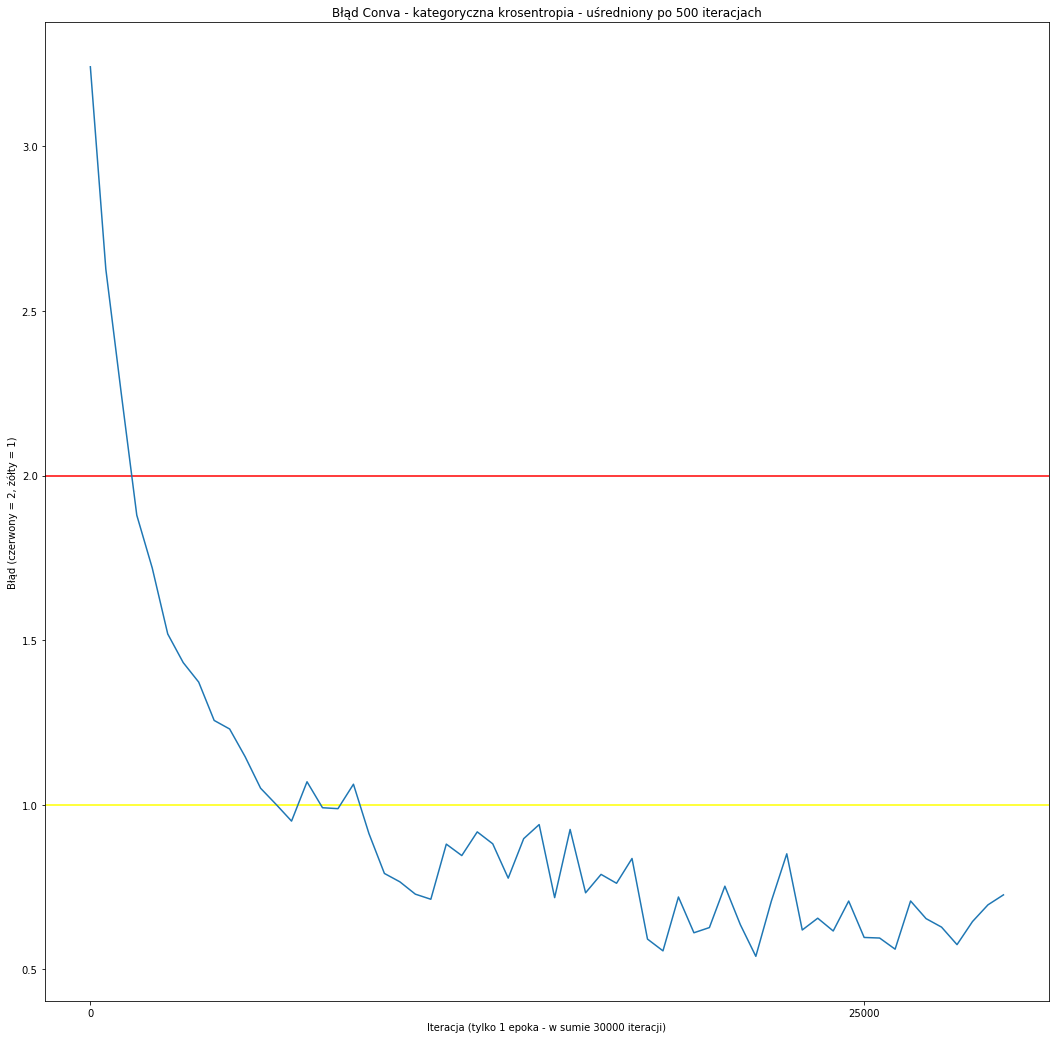

In [40]:
print(w2.shape)
fig, ax=plt.subplots(1, 1, figsize=(18,18))
dt=loopz
kgbo=500
dt2=dt//kgbo

dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(sk[i*kgbo:(i+1)*kgbo])/kgbo

ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko 1 epoka - w sumie {} iteracji)'.format(loopz))
ax.set_xticklabels(range(0, loopz+1, kgbo*50))
ax.set_xticks(range(0, loopz//kgbo+1, 50))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1)'.format(loopz))
ax.axhline(2, color='red')
ax.axhline(1, color='yellow')
ax.plot(dkkk)
plt.show()

In [41]:
num=3000
won=0

for jj in range(num):
    img=testX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])

    """m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    s2=sigmoid_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[testy[jj],0]=1
    der, suma=cost(dp, s4)
    mxi=0
    for i in range(10):
        if (s4[i,0]>s4[mxi,0]):
            mxi=i
    if (mxi==testy[jj]):
        won+=1    
    #print(mxi, testy[jj])
print('Skutecznosc na {} testach: {}'.format(num, won/num))

Skutecznosc na 3000 testach: 0.8823333333333333


In [32]:
##Od tego miejsca śmieci do debugu
###
###
###


k1=np.asarray([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
k1=k1.reshape(k1.shape[0], k1.shape[1], 1)
mathr=np.asarray([[1,2,3],[-1,-2,-3],[-10,10,20]])
c1=conv_forw(k1, mathr)
#c1=c1.reshape(c1.shape[0], c1.shape[1])
kgb=pool_forw(k1, (2,2))

print(kgb[1].reshape(kgb[1].shape[0], kgb[1].shape[1]))


[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]]


In [139]:
dkk=[0]*10
for i in range(100):
    dkk[testy[i]]+=1
print(dkk)


#print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2].shape)
#print(print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]))
#print(z)
#TT=(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]==z)
#print(TT[TT==False])

[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]


(1048, 698, 3) (7, 7)
2 2
(1050, 705, 3) (7, 7)
(150, 100)
150 100


In [17]:
mat=mymat
Y=np.ndarray((z.shape[0]*mat.shape[0], z.shape[1]*mat.shape[1]*3, z.shape[2]*2), dtype='float64')
t1=time.time()
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        for ij in range(z.shape[2]):
            Y[i:i+1,j,ij]=1
t2=time.time()
print(t2-t1)
print(Y.shape[0]*Y.shape[1]*Y.shape[2])

7.269612789154053
29625912


In [10]:
k=[random.random() for i in range(10)]
print(k)

[0.5984270187569013, 0.9671677742926911, 0.7976401137331915, 0.053760428992956966, 0.25749371422047285, 0.16253284123891132, 0.9060344103299387, 0.2756248627348449, 0.5445703657707015, 0.39006604163079217]


In [ ]:
z=cv2.imread("E:\W3\GGHard.jpg")
#z=z/255
mymat=np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
z=conv_forw(z, mymat)
z=relu(z)
t1=time.time()
z, dt=pool_forw(z,(7,7))
t2=time.time()
print(t2-t1)
print(dt.shape)
#z=pool(z,(7,7))

"""fig, ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(z)
ax.axis('off')
plt.show()"""

In [ ]:
def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_forw2(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')    
    
    print(Z.shape[0]*Z.shape[1]*mat.shape[0]*mat.shape[0])
    xz1=mat.shape[0]
    xz2=mat.shape[1]
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            ii=0
            while (ii<xz1):
                jj=0
                while(jj<xz2):
                    Z[i,j]=1
                    jj+=1
                ii+=1
    return Z
            
B=np.asarray([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kurl=r"E:\W3\GGHard.jpg"
kk=cv2.imread(kurl)

t1=time.time()
nightmare=conv_forw2(kk, B)
t2=time.time()
print(t2-t1)
t1=time.time()
nightmare2 = ndimage.convolve(kk.astype('int64'), B.reshape(3,3,1))
t2=time.time()
print(t2-t1)

fig, ax=plt.subplots(1,2,figsize=(22,22))
ax[0].imshow(nightmare2)
ax[0].axis('off')
ax[1].imshow(nightmare)
ax[1].axis('off')
plt.show()

In [ ]:
print(kk.shape)
print(nightmare2[1:nightmare2.shape[0]-1,1:nightmare2.shape[1]-1])
print(nightmare)

def relu(x):
    if (x<0):
        return 0
    return x

def pool_forward(X):
    Y=pd.Series([True]*X.shape[0])
    Y2=pd.Series([True]*X.shape[1])
    
    Y[Y.index%2==0]=False
    Y2[Y2.index%2==0]=False 
    KK1=X[Y][:,Y2]
    KK2=X[Y][:,~Y2]
    KK3=X[~Y][:,Y2]
    KK4=X[~Y][:,~Y2]
    
    Dt=KK1*0+1
    Exit=KK1
    Dt[Exit<KK2]=2
    Exit[Exit<KK2]=KK2[Exit<KK2]
    Dt[Exit<KK3]=3
    Exit[Exit<KK3]=KK3[Exit<KK3]
    Dt[Exit<KK4]=4
    Exit[Exit<KK4]=KK3[Exit<KK4]
    
    return (Dt, KK1)

t1=time.time()
Res, KK=pool_forward(nightmare)
t2=time.time()
print(t2-t1)

print(nightmare[:4,:4,0])

#Dodanie wersetu w 2 wymiarze
print(KK.shape)
s=[0]*KK.shape[0]*KK.shape[2]
s=np.asarray(s).reshape(KK.shape[0], 1, 3)
GG=np.append(KK, s, axis=1)
print(GG.shape)

In [98]:
n1, n2 = np.arange(5), np.arange(5)
Y=m7[0]
n1=np.arange(m7[0].shape[0])

f1=pd.Series([1]*Y.shape[0])
f2=pd.Series([1]*Y.shape[1])
f3=pd.Series([1]*Y.shape[2])

n1=np.asarray(f1[(f1.index%2)==0].index)
n2=np.asarray(f2[(f2.index%2)==1].index)
n3=np.asarray(f3.index)

m7[0][n1,n2]=13
print(m7[0][np.ix_(n1, n2,n3)].shape)
print(m7[0].shape)

(3, 3, 3)
(6, 6, 3)


In [119]:
print(math.exp(-100000))

0.0


In [71]:
print(matt)

[[[-1.80641111e-01  1.01303406e+00  5.68658521e-02]
  [-1.50180242e-01 -4.49518778e-01  2.29888229e-01]
  [-1.49464212e-01  1.79568202e-02  5.63098800e-01]]

 [[ 3.57100431e-01 -1.24985684e-01 -1.44566969e-01]
  [ 5.21873333e-01  9.49807180e-01  8.12153844e-01]
  [-1.77566089e-01 -6.69357460e-01  4.61081356e-01]]

 [[ 8.51013511e-01 -3.23042716e-01 -5.74604168e-01]
  [ 1.54445548e-01 -2.12365245e-01 -6.03171539e-01]
  [ 1.08646375e+00 -3.59921150e-01 -3.14678410e-01]]

 [[-3.09463601e-01 -8.49167675e-01  4.21892386e-01]
  [-9.78466819e-02  4.85793427e-01  4.07272130e-01]
  [-4.93156935e-01 -2.03789750e-01 -7.12313815e-02]]

 [[-8.53628217e-02 -7.04846645e-04  6.31339778e-03]
  [ 5.44888689e-01 -4.57835885e-01 -4.06130290e-01]
  [-7.09531689e-02 -4.13826322e-01  3.46471223e-01]]

 [[-3.29109786e-01  6.69617081e-01  4.80251536e-01]
  [-4.98654748e-01  5.22653924e-02 -4.02342825e-01]
  [ 3.54233047e-01 -4.11030534e-01 -4.91160409e-02]]

 [[-1.87180082e-01  8.45536081e-04  4.05606974e-02]
